In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from subprocess import call
from recsys.models import BPR
from recsys.metrics import auc_score
from recsys.utils import create_matrix
from recsys.model_selection import create_train_test

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,recsys

Ethen 2017-03-30 09:47:58 

CPython 3.5.2
IPython 5.1.0

numpy 1.12.0
pandas 0.19.2
matplotlib 1.5.3
recsys 0.0.1


In [2]:
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep = '\t', names = names)
print('data dimension: \n', data.shape)
data.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
item_col = 'item_id'
user_col = 'user_id'
rating_col = 'rating'
rating_threshold = 3
X, data = create_matrix(data, user_col, item_col, rating_col, 
                        rating_threshold = rating_threshold)
X

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 82520 stored elements in Compressed Sparse Row format>

In [4]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)
X_train

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 65641 stored elements in Compressed Sparse Row format>

In [5]:
bpr_params = {
    'n_factors': 20,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2000 
}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 10/10 [01:15<00:00,  7.29s/it]


BPR(learning_rate=0.05, n_batch_size=2000, n_factors=20, n_iters=10, reg=0.01,
  seed=1234, verbose=True)

In [6]:
print(auc_score(bpr, X_train))
print(auc_score(bpr, X_test))

0.947667890415
0.898771686805


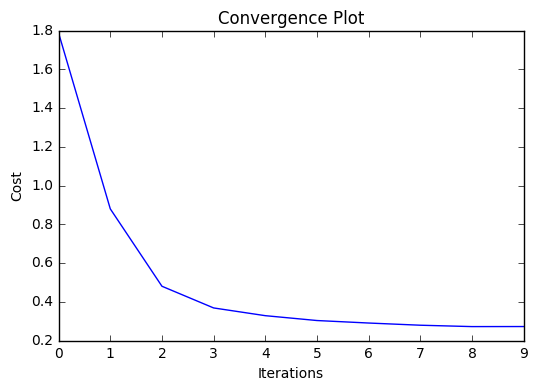

In [7]:
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

plt.plot(bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [8]:
similar_items = bpr.get_similar_items(N = 5)
similar_items

array([[  49,  116,  150,  180,  236],
       [ 401,  232,  127,  801,  548],
       [ 408,  621,  452,  128,  585],
       ..., 
       [1391, 1522, 1467, 1416, 1443],
       [1429, 1445, 1562, 1350, 1559],
       [1166, 1473, 1433, 1445, 1222]], dtype=int32)

In [9]:
recommendation = bpr.recommend(X_train, N = 5)
recommendation

array([[  6,  69, 274,  41, 355],
       [ 99, 326, 317,   8, 293],
       [301, 867, 300, 299, 244],
       ..., 
       [126,  49,  99,  24, 465],
       [287,  99, 293, 171, 285],
       [143,   0,  81, 203,   6]], dtype=int32)